# Image classification with Tensorflow Estimator API
This kernel uses the TensorFlow high-level Estimator API. The model is built using transfer learning with a model from the TensorFlow Hub.

# Kaggle set-up

In [1]:
!pip install kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "there25sia" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file

In [5]:
!kaggle competitions download -c aptos2019-blindness-detection

  0% 0.00/207k [00:00<?, ?B/s]
100% 207k/207k [00:00<00:00, 76.1MB/s]
  0% 0.00/219k [00:00<?, ?B/s]
100% 219k/219k [00:00<00:00, 139MB/s]
  0% 0.00/223k [00:00<?, ?B/s]
100% 223k/223k [00:00<00:00, 67.1MB/s]
  0% 0.00/926k [00:00<?, ?B/s]
100% 926k/926k [00:00<00:00, 61.3MB/s]
  0% 0.00/226k [00:00<?, ?B/s]
100% 226k/226k [00:00<00:00, 203MB/s]
  0% 0.00/230k [00:00<?, ?B/s]
100% 230k/230k [00:00<00:00, 71.2MB/s]
  0% 0.00/2.14M [00:00<?, ?B/s]
100% 2.14M/2.14M [00:00<00:00, 147MB/s]
  0% 0.00/2.00M [00:00<?, ?B/s]
100% 2.00M/2.00M [00:00<00:00, 136MB/s]
  0% 0.00/224k [00:00<?, ?B/s]
100% 224k/224k [00:00<00:00, 75.6MB/s]
  0% 0.00/229k [00:00<?, ?B/s]
100% 229k/229k [00:00<00:00, 71.3MB/s]
  0% 0.00/982k [00:00<?, ?B/s]
100% 982k/982k [00:00<00:00, 63.8MB/s]
  0% 0.00/221k [00:00<?, ?B/s]
100% 221k/221k [00:00<00:00, 69.4MB/s]
  0% 0.00/198k [00:00<?, ?B/s]
100% 198k/198k [00:00<00:00, 62.3MB/s]
  0% 0.00/2.08M [00:00<?, ?B/s]
100% 2.08M/2.08M [00:00<00:00, 69.0MB/s]
  0% 0.00/232k 

# 

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

## Data set
The training data set is described in a .csv file with image IDs and labels. There are 5 classes named 0 to 4.

In [2]:
train_file='../input/aptos2019-blindness-detection/train.csv'
df=pd.read_csv(train_file)
cat_cnt=df['diagnosis'].value_counts().sort_index()
train_image_count=np.sum(cat_cnt)
print("Train data set count: ", train_image_count)

Train data set count:  3662


In [3]:
print(os.listdir("../input/aptos2019-blindness-detection"))

['test_images', 'train.csv', 'test.csv', 'train_images', 'sample_submission.csv']


## Pre-trained model
The base model can be picked from TensorFlow Hub, and can be changed in one line below. A pre-trained model is usually made for a specific input image size, and thankfully we can get that parameter from the hub. Here we pick the NASNet-A model:

In [4]:
USE_INTERNET = False

if USE_INTERNET:
    %env TFHUB_CACHE_DIR=./tfhub_cache/imagenet/feature_vector
    mod_link="https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/3"
    mod_name=mod_link.split('imagenet/')[1].split('/')[0]
    input_img_size = hub.get_expected_image_size(hub.Module(mod_link))
else:
    mod_link="../input/tfhub-cache/nasnet_large/nasnet_large"
    mod_name='nasnet'
    input_img_size = [331, 331]

print("Expected input size for {} is:".format(mod_name), input_img_size)

Expected input size for nasnet is: [331, 331]


The data set is small (and heavily skewed), and the pre-trained model has never seen retina photos before - what could possibly go wrong? Let's find out...

## Input function
First step is to make an input function that will serve the model with data (TensorFlow dataset). Preprocessing steps are collected in the `_preproc_image()` function that is common for TRAIN, EVAL and PREDICT steps.

In [5]:
def _preproc_image(file, img_size):
    image = tf.read_file(file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image /= 255.0  # normalize to [0,1] range
    return image

The input function below is used for TRAIN and EVAL. The AUTOTUNE option is used to let TensorFlow use available compute resources effectively. The images in this data set are generally large, and thus the preprocessing step could be the bottleneck rather than train step. The image files are shuffle and split into TRAIN and EVAL. Measures are taken here to ensure even distribution of the different categories in each mini-batch. 

In [6]:
SPLIT=0.804 # train/eval
AUTOTUNE = tf.data.experimental.AUTOTUNE

def imgs_input_fn(filename, batch_size=32, mode = tf.estimator.ModeKeys.TRAIN, total_images=1000, img_size=[200,200]):

    def _agument_image(image):
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_flip_left_right(image)        
        return image
    
    def _proc_image(file, label=None):
        image = _preproc_image(tf.strings.join([tf.strings.join(["../input/aptos2019-blindness-detection/train_images",file], "/"), "png"], "."),
                              img_size)
        # Images is agumented in the TRAIN phase only
        if mode == tf.estimator.ModeKeys.TRAIN:
            image = _agument_image(image)
        return { 'image': image}, label
     
    dataset_raw = tf.data.experimental.CsvDataset(filename, [tf.string, tf.string], header=True)
    dataset_raw = dataset_raw.shuffle(total_images, seed=1)
    train_cnt = int(SPLIT*total_images)
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset_raw = dataset_raw.take(train_cnt)
        d0 = dataset_raw.filter(lambda file, label: tf.math.equal(label, '0')).repeat()
        d1 = dataset_raw.filter(lambda file, label: tf.math.equal(label, '1')).repeat()
        d2 = dataset_raw.filter(lambda file, label: tf.math.equal(label, '2')).repeat()
        d3 = dataset_raw.filter(lambda file, label: tf.math.equal(label, '3')).repeat()
        d4 = dataset_raw.filter(lambda file, label: tf.math.equal(label, '4')).repeat()
        dataset = tf.data.experimental.sample_from_datasets([d0, d1, d2, d3, d4])
    elif mode == tf.estimator.ModeKeys.EVAL:
        dataset = dataset_raw.skip(train_cnt)
        
    dataset = dataset.map(_proc_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return dataset

## Define model configuration
Models are saved into separate `models` directories - useful when testing and comparing different pre-trained models.

In [7]:
model_dir = os.path.join(os.getcwd(), "./models/{}").format(mod_name)
os.makedirs(model_dir, exist_ok=True)
#%load_ext tensorboard
#%tensorboard --logdir {model_dir} # can access from http://localhost:6006
print("model_dir: ",model_dir)
config = tf.estimator.RunConfig(
    model_dir=model_dir,
    save_summary_steps=100,
    save_checkpoints_steps=100,
    keep_checkpoint_max=2,
    log_step_count_steps=10)

model_dir:  /kaggle/working/./models/nasnet


## Define model function
The pre-trained model is used directly, with just a softmax layer with 5 classes on top. Additionally, the multi_class_head function is used that takes care of some details for us. The loss function it uses by default is `sparse_softmax_cross_entropy` loss. There are many useful discussions on using transfer learning for image classification, [for example this one](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)

In [8]:
NUM_CLASSES = 5

def model_fn(features, labels, mode, params):
    module = hub.Module(mod_link, trainable=False, name=mod_name)
    feature_vec = module(features['image'])
    #dropout = tf.layers.dropout(inputs=feature_vec, rate=0.1, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.Dense(NUM_CLASSES)(feature_vec)
    head = tf.contrib.estimator.multi_class_head(n_classes=NUM_CLASSES, label_vocabulary=['0','1','2','3','4'])
    optimizer = tf.train.AdamOptimizer(learning_rate=0.003)
    return head.create_estimator_spec(
        features, mode, logits, labels, optimizer=optimizer
    )

## Setup the Estimator
The last thing remaining is to setup the estimator and then run training. The model is saved automatically in the model directory defined above.

In [9]:
BATCH_SIZE = 40
MAX_STEPS = 1250

train_spec = tf.estimator.TrainSpec(input_fn=lambda: imgs_input_fn(train_file, 
                                                                   batch_size=BATCH_SIZE,
                                                                   mode = tf.estimator.ModeKeys.TRAIN, 
                                                                   total_images=train_image_count,
                                                                   img_size=input_img_size),
                                   max_steps=MAX_STEPS)
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: imgs_input_fn(train_file, 
                                                                   batch_size=BATCH_SIZE,
                                                                   mode = tf.estimator.ModeKeys.EVAL, 
                                                                   total_images=train_image_count,
                                                                   img_size=input_img_size))
classifier = tf.estimator.Estimator(
        model_fn=model_fn,
        model_dir=model_dir,
        config=config,
        params=[]
    )

tf.logging.set_verbosity(tf.logging.INFO)
tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)

({'accuracy': 0.80083567,
  'average_loss': 0.5141071,
  'loss': 0.5134689,
  'global_step': 1250},
 [])

# Making predictions
The test images for prediction is located in the `test_images` directory, and we simply make a list of all the files.

In [10]:
import pathlib
import glob
test_set = [str(path) for path in list(pathlib.Path('../input/aptos2019-blindness-detection/test_images/').glob('*.png'))]

## Predict input function
To prevent cluttering up the input function used for training, a separate input function is defined for the predict step. 

In [11]:
def pred_input_fn(filelist, batch_size=32, pred_images=100, img_size=[200,200]):
    
    def _proc_image(file):
        image = _preproc_image(file, img_size)
        return { 'image': image}
     
    dataset = tf.data.Dataset.from_tensor_slices(filelist)  
    dataset = dataset.take(pred_images)
    dataset = dataset.map(_proc_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return dataset

## Predict
Predictions is then just a matter of calling the .predict method.

In [12]:
predictions = classifier.predict(input_fn=lambda: pred_input_fn(test_set, 
                                                                batch_size=32,
                                                                pred_images=len(test_set),
                                                                img_size=input_img_size))

NOTE! Nothing happens after the above line - need to iterate through `predictions` to get it going.
Each prediction will be a dict with this format:

`{'logits': array([ 0.5168798,  1.1608064,  3.1475224, -5.6981955,  0.5543511], dtype=float32), 
  'probabilities': array([5.6095276e-02, 1.0680217e-01, 7.7875328e-01, 1.1213811e-04, 5.8237117e-02], dtype=float32), 
  'class_ids': array([2], dtype=int64), 
  'classes': array([b'2'], dtype=object), 
  'all_class_ids': array([0, 1, 2, 3, 4]), 
  'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}`
  
The payload we are interested in can be found under `class_ids`. Let's create a Pandas dataframe while iterating through the predictions:

In [13]:
fl=test_set.copy()
df=pd.DataFrame([(fl.pop(0).split("test_images/")[1].split(".")[0], 
                p['class_ids'][0], p['probabilities'][p['class_ids'][0]]) for p in predictions], 
                columns=['id_code', 'diagnosis', 'probability'])

Take a look at the first few predictions. The probability of each prediction is also included here for information.

In [14]:
df.head(5)

,id_code,diagnosis,probability
0,8bbef4ac9702,3,0.726064
1,8b83f4b2d1a9,3,0.418674
2,352fe3e5b3fe,1,0.505660
3,aa2c125a8ab8,2,0.550215
4,c370a38c855e,2,0.709374


Also look at predictions stats:

In [15]:
df.describe()

,diagnosis,probability
count,1928.000000,1928.000000
mean,2.103734,0.661171
std,1.204828,0.193928
min,0.000000,0.267466
25%,1.000000,0.499429
50%,2.000000,0.644425
75%,3.000000,0.824917
max,4.000000,0.999599


## Submit
Finally, the result is submitted to a .csv file:

In [16]:
df.to_csv('submission.csv', columns=['id_code', 'diagnosis'], index=None)

## Final comments
This kernel scored ~0.57. Some serious feature engineering is needed to properly adapt and train this model. The large image size in the data set really puts the CPU resources under pressure. On a desktop (i7-3930K + RTX2070), the whole notebook runs in ~20min. On Kaggle, the runtime is ~75min. Let's take a look at the predictions with a graphical view:

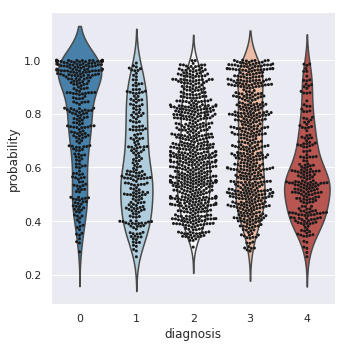

In [17]:
import seaborn as sns
sns.set()
cp = sns.catplot(x="diagnosis", y="probability", kind="violin", inner=None, data=df, palette=sns.color_palette("RdBu_r", 5))
sns.swarmplot(x="diagnosis", y="probability", color="k", size=3, data=df, ax=cp.ax);